# Image reconstruction with Partial Fourier

[![View on website](https://img.shields.io/badge/-View%20on%20website-128091?labelColor=grey&logo=)](https://mrphys.github.io/tensorflow-mri/tutorials/recon/cg_sense)
[![Run in Colab](https://img.shields.io/badge/-Run%20in%20Colab-128091?labelColor=grey&logo=googlecolab)](https://colab.research.google.com/github/mrphys/tensorflow-mri/blob/master/tools/docs/tutorials/recon/cg_sense.ipynb)
[![View on GitHub](https://img.shields.io/badge/-View%20on%20GitHub-128091?labelColor=grey&logo=github)](https://github.com/mrphys/tensorflow-mri/blob/master/tools/docs/tutorials/recon/cg_sense.ipynb)
[![Download notebook](https://img.shields.io/badge/-Download%20notebook-128091?labelColor=grey&logo=)](https://raw.githubusercontent.com/mrphys/tensorflow-mri/master/tools/docs/tutorials/recon/cg_sense.ipynb)

## Set up TensorFlow MRI
If you have not yet installed TensorFlow MRI in your environment, you may do so
now using `pip`: 

In [2]:
%pip install --quiet tensorflow-mri
# Upgrade Matplotlib. Versions older than 3.5.x may cause an error below.
%pip install --quiet --upgrade matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Then, import the package into your program to get started:

In [3]:
import tensorflow_mri as tfmri
print("TensorFlow MRI version:", tfmri.__version__)

2025-01-13 23:44:47.289568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 23:44:47.385273: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 23:44:47.411486: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow MRI version: 0.22.0


We will also need a few additional packages:

In [4]:
import h5py
import matplotlib.collections as mcol
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Using a GPU

TensorFlow MRI supports CPU and GPU computation. If there is a GPU available in
your environment and it is visible to TensorFlow, it will be used automatically.

:::{tip}
In Google Colab, you can enable GPU computation by clicking on
**Runtime > Change runtime type** and selecting **GPU** under
**Hardware accelerator**.
:::

:::{tip}
You can control whether CPU or GPU is used for a particular operation via
the [`tf.device`](https://www.tensorflow.org/api_docs/python/tf/device)
context manager.
:::

## Prepare the data
We will be using an example brain dataset from the
[ISMRM Reproducibility Challenge 1](https://ismrm.github.io/rrsg/challenge_one/).
Let's download it.

In [5]:
cardiac_cine_data_filename = 'fs_0005_1_5T.h5'
cardiac_cine_data_url = "https://ocmr.s3.us-east-2.amazonaws.com/data/fs_0005_1_5T.h5."
!wget --quiet -O {cardiac_cine_data_filename} {cardiac_cine_data_url}

/bin/bash: wget: command not found


This dataset contains a fully sampled cartesian dataset. from the OCMR dataset:
https://github.com/MRIOSU/OCMR/blob/master/Python/example_ocmr.ipynb
The data is stored
in a HDF5 file, which we can read using [h5py](https://www.h5py.org/). The
downloaded file also has the sampling locations or *k*-space trajectory, so we
do not need to calculate it.

In [6]:
# read_ocmr is downloaded from here:
# https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

import read_ocmr as read

kData,param = read.read_ocmr(cardiac_cine_data_filename)
print('Dimension of kData: ', kData.shape)

kData = np.squeeze(kData)
print('Dimension of kData: ', kData.shape)
# kx, ky, ch, phase

# Reverse the order of the dimensions.
# [kx, ky, ch, phase] -> [phase, ch, kx, ky ]
kspace = np.transpose(kData, [3,2,0,1])
print(kspace.shape)
#(18, 18, 512, 208)
#[phase, ch, kx, ky ]


Imaging acquisition starts acq  0
Dimension of kData:  (512, 208, 1, 18, 18, 1, 1, 1, 1)
Dimension of kData:  (512, 208, 18, 18)
(18, 18, 512, 208)


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [8]:
# Here simulate the partial fourier with 60% of lines collected (by removing the lower 40% of k-space)

kspace_PF = np.squeeze(kspace[:,:,:,:int(0.6*np.shape(kspace)[3])])
print(np.shape(kspace_PF))
#(18, 18, 256, 124)
#[phase, ch, kx, ky ]



(18, 18, 512, 124)


In [9]:
# Now reconstruction each time point seperately
Reconstructed_Image = []
for t in range(np.shape(kspace_PF)[0]):

    kspace_PF_single_phase = np.squeeze(kspace_PF[t,:,:,:])
    #[ch, kx, ky ]
    print(kspace_PF_single_phase.shape)
    #(18, 512, 124)

    recon_im = tfmri.recon.partial_fourier(
            kspace_PF_single_phase, [1.0, 0.6], method='zerofill',
            preserve_phase=False)
    print(recon_im.shape)
    #(18, 512, 207)
    #[ch, x, y ]

    Reconstructed_Image.append(recon_im)

(18, 512, 124)


2025-01-13 23:45:03.966360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 23:45:04.465216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22173 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)


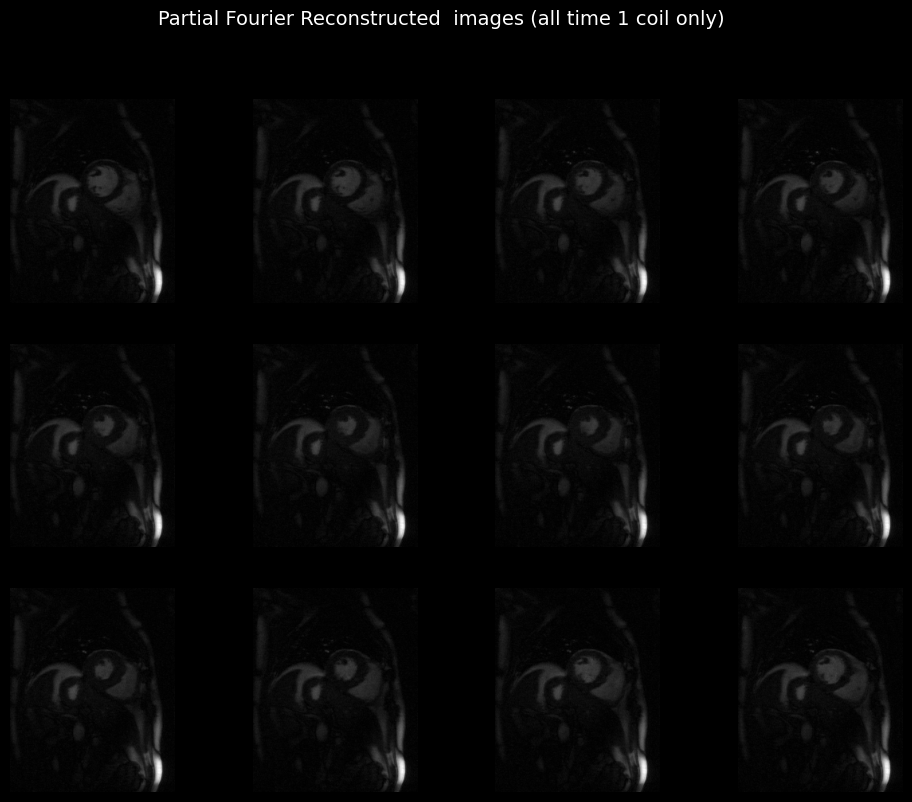

In [15]:
def plot_tiled_images(image):
  _, axs = plt.subplots(3, 4, facecolor='k', figsize=(12, 9))

  artists = []
  for index in range(12):
    col, row = index // 4, index % 4
    artists.append(
        axs[col, row].imshow(image[index, ...], cmap='gray')
    )
    axs[col, row].axis('off')
  return artists

final_cine = np.array(Reconstructed_Image)
#remove RO oversampling
ROsize = final_cine.shape[2]
final_cine = final_cine[:,:,int(ROsize/4):int(3*ROsize/4),:]
 #[ph,ch, x, y ]
_ = plot_tiled_images(np.squeeze(tf.math.abs(final_cine[:,2,:,:])))
_ = plt.gcf().suptitle('Partial Fourier Reconstructed  images (all time 1 coil only)',
                       color='w', fontsize=14)

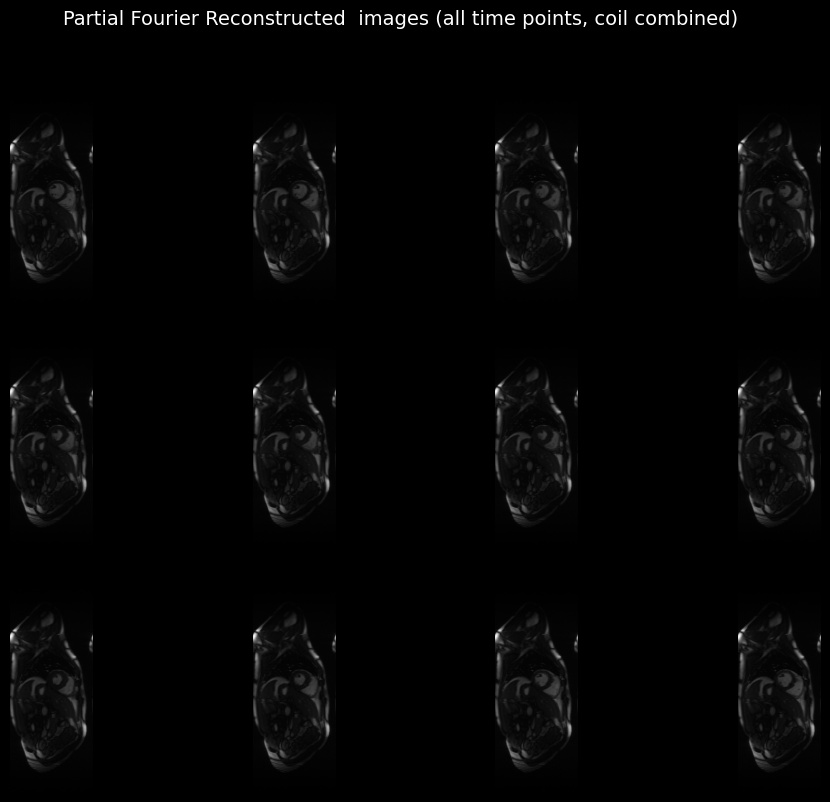

In [11]:
# now do coil combination

coil_combined_cine = tfmri.coils.combine_coils(final_cine, maps=None, coil_axis= 1)

_ = plot_tiled_images(np.squeeze(tf.math.abs(coil_combined_cine)))
_ = plt.gcf().suptitle('Partial Fourier Reconstructed  images (all time points, coil combined)',
                       color='w', fontsize=14)

(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)
(18, 512, 124)
(18, 512, 207)


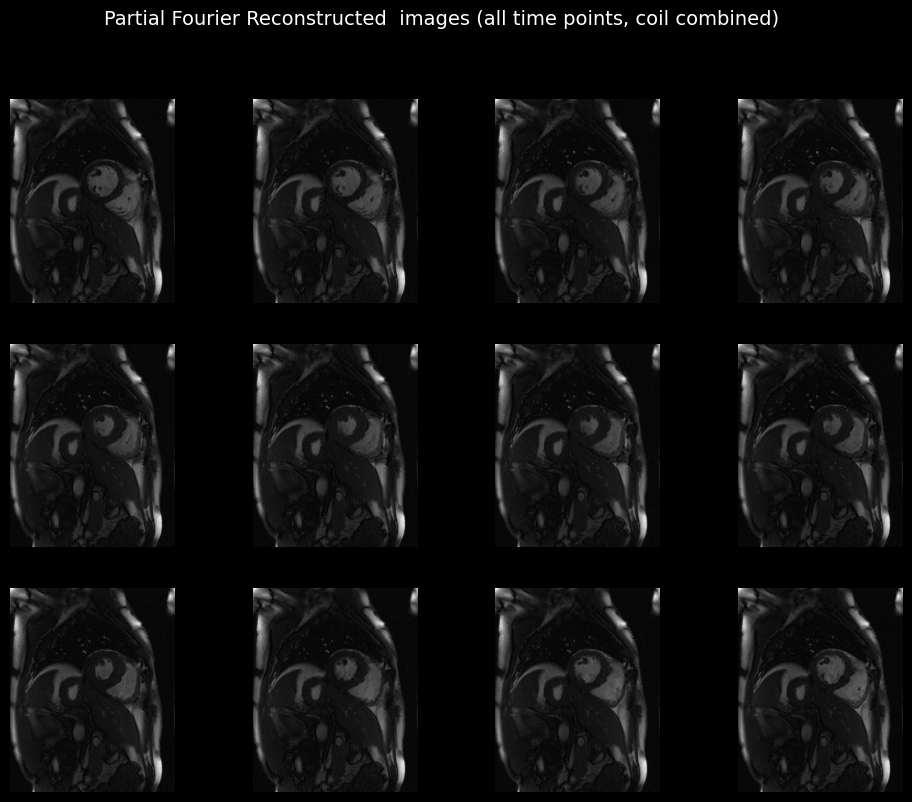

In [17]:
# HEre try to recon the PF daya with Homodyne

# Now reconstruction each time point seperately
Reconstructed_ImageHomodyne = []
for t in range(np.shape(kspace_PF)[0]):

    kspace_PF_single_phase = np.squeeze(kspace_PF[t,:,:,:])
    #[ch, kx, ky ]
    print(kspace_PF_single_phase.shape)
    #(18, 512, 124)

    recon_im = tfmri.recon.partial_fourier(
            kspace_PF_single_phase, [1.0, 0.6], method='homodyne',
            preserve_phase=True, return_kspace= False)
    print(recon_im.shape)
    #(18, 512, 207)
    #[ch, x, y ]

    Reconstructed_ImageHomodyne.append(recon_im)

final_cineHomodyne = np.array(Reconstructed_ImageHomodyne)
#remove RO oversampling
ROsize = final_cineHomodyne.shape[2]
final_cineHomodyne = final_cineHomodyne[:,:,int(ROsize/4):int(3*ROsize/4),:]
coil_combined_HomodyneCine = tfmri.coils.combine_coils(final_cineHomodyne, maps=None, coil_axis= 1)

_ = plot_tiled_images(np.squeeze(tf.math.abs(coil_combined_HomodyneCine)))
_ = plt.gcf().suptitle('Partial Fourier Reconstructed  images (all time points, coil combined)',
                       color='w', fontsize=14)

## Conclusion
Congratulations! You performed a partial Fourier reconstruction using
TensorFlow MRI. The code used in this notebook works for any amount of partial Fourier.
 It also works for 3D imaging. Feel free to try with your own data!

For more information about the functions used in this tutorial, check out the
[API documentation](https://mrphys.github.io/tensorflow-mri/api_docs/). For
more examples of using TensorFlow MRI, check out the
[tutorials](https://mrphys.github.io/tensorflow-mri/tutorials/).

### Let us know!
Please tell us what you think about this tutorial and about TensorFlow MRI.
We would like to hear what you liked and how we can improve. You will find us
on [GitHub](https://github.com/mrphys/tensorflow-mri/issues/new).

In [13]:
# Copyright 2022 University College London. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.